In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms

In [2]:
# hyper parameters:
input_size = 784  # 28X28 pixel of image

hidden_size1 = 200  # size of 1st hidden layer
hidden_size2 = 150  # size of second hidden layer

output = 10  # output layer, number of classes

num_epoch = 2
bach_size = 100
lr_rate = 0.01

In [3]:
# start data loading
train_dataset = torchvision.datasets.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    "./data", train=False, transform=transforms.ToTensor(), download=False
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=bach_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=bach_size, shuffle=False
)

0.1%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


67.4%

102.8%
0.2%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


112.7%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# check status of training data
data = iter(train_dataloader)
samples, labels = next(data)
print(f"number of samples{samples.shape}")
print(f"number of labels {labels.shape}")

# check number of train/test data
print(len(train_dataloader))
print(len(test_dataloader))

number of samplestorch.Size([100, 1, 28, 28])
number of labels torch.Size([100])
600
100


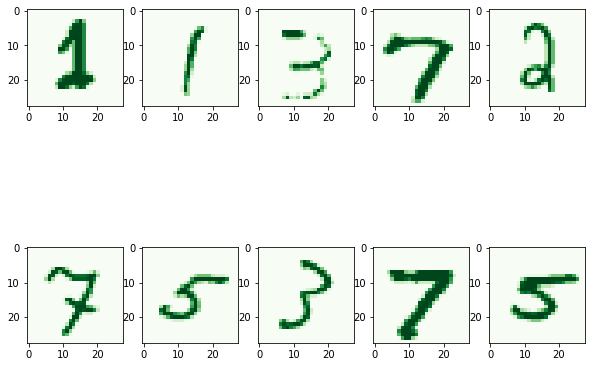

In [5]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i][0], cmap="Greens")
plt.show()

In [6]:
# define neural network
class MyMLP1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output):
        super().__init__()
        self.f_connected1 = nn.Linear(input_size, hidden_size1)
        self.f_connected2 = nn.Linear(hidden_size1, hidden_size2)
        self.out_connected = nn.Linear(hidden_size2, output)

    def forward(self, X):
        out = F.relu(self.f_connected1(X))
        out = F.relu(self.f_connected2(out))
        out = self.out_connected(out)
        return out


# define neural network
class MyMLP2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.out_connected = nn.Linear(hidden_size2, output)

    def forward(self, X):
        out = self.l1(X)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.out_connected(out)
        return out


# create an empty model with given parameters
Mnist_model = MyMLP2(input_size, hidden_size1, hidden_size2, output)
print(Mnist_model)

MyMLP2(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=200, out_features=150, bias=True)
  (out_connected): Linear(in_features=150, out_features=10, bias=True)
)


In [7]:
# another method, but not as flexiable as method 1
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for block in args:
            self._modules[block] = block

    def forward(self, X):
        for block in self._modules.values():
            X = block(X)
        return X


# create an empty model with given parameters
Mnist_model_v2 = MySequential(
    nn.Linear(input_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, output),
)

In [8]:
# define other parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Mnist_model.parameters(), lr=lr_rate)

# training
n_total_steps = len(train_dataloader)
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, 28 * 28)

        # forward
        outputs = Mnist_model(images)
        loss = criterion(outputs, labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"epoch {epoch+1}/{num_epoch}, step {i+1}/{n_total_steps}, loss = {loss.item():4f}"
            )


# testing
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in test_dataloader:
        images = images.reshape(-1, 28 * 28)
        outputs = Mnist_model(images)

        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f"accuracy = {acc}")

epoch 1/2, step 100/600, loss = 0.332737
epoch 1/2, step 200/600, loss = 0.190141
epoch 1/2, step 300/600, loss = 0.071619
epoch 1/2, step 400/600, loss = 0.305623
epoch 1/2, step 500/600, loss = 0.168318
epoch 1/2, step 600/600, loss = 0.137809
epoch 2/2, step 100/600, loss = 0.117358
epoch 2/2, step 200/600, loss = 0.094083
epoch 2/2, step 300/600, loss = 0.078246
epoch 2/2, step 400/600, loss = 0.200581
epoch 2/2, step 500/600, loss = 0.103734
epoch 2/2, step 600/600, loss = 0.092008
accuracy = 96.31
